This is the training script for our best performing models (pre-trained ResNet by PyTorch)

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
import random
import os
import csv

from Config import Config
from Models import PreTrainedKPD, Tools

/Users/julienstal/Library/Python/3.9/lib/python/site-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 1.4.22 (you have 1.4.21). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [3]:
def split_data(data, test_size=0.15, random_seed=None):
    """
    Split dataset into train and test datasets. In our case, datasets are lists of dictionaries which
    contain entries: "Image Name", "x1", "y1", "x2", "y2"
    
    Parameters:
        data (list of dict): The input data to be split.
        test_size (float): Proportion of the dataset to include in the test split (default is 0.2).
        random_seed (int, optional): Random seed for reproducibility (default is None).
    
    Returns:
        tuple: (train_data, test_data) where both are lists of dictionaries.
    """
    if random_seed is not None:
        random.seed(random_seed)
    
    # Shuffle the data
    shuffled_data = data[:]
    random.shuffle(shuffled_data)
    
    # Compute the split index
    split_idx = int(len(shuffled_data) * (1 - test_size))
    
    # Split the data
    train_data = shuffled_data[:split_idx]
    test_data = shuffled_data[split_idx:]
    
    return train_data, test_data

In [4]:
"""
Create datasets by reading the csv files that contain the coordinates.
"""
with open(Config.coords_file_path, mode='r') as file:
    reader = csv.DictReader(file)  # Use DictReader to automatically map rows to dictionaries
    data = [row for row in reader]  # Convert each row into a dictionary and store in a list

train_data, test_data = split_data(data)
print(f"{len(train_data)} training points and {len(test_data)} test points.")

3262 training points and 576 test points.


In [5]:
# MPS is the CUDA (GPU) equivalent on Macs for much faster training.
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(f"Training on device: {device}")

Training on device: mps


In [ ]:
"""
Create and train keypoint detection model. 
The KeypointDetection Model (KPD) takes images as inputs and learns to find the two points defining Weber's length.
Note: we keep track and restore the best performing version on the test dataset to avoid overfitting

The model was pretrained on general images and we modified it for keypoint detection. Here we start by introducing it to
the specific demands of our problem by training it on AUGMENTED images which will still allow some room for some finetuning
with non-augmented images later.
"""
kpd_model = PreTrainedKPD.KeypointDetectionModel().to(device)
Tools.train_kpd_model(kpd_model, train_data, test_data, 50, 401, feedback_rate=50, initial_lr=1e-4, augment_training_images=True, plot_progression=True)

In [8]:
best_state = kpd_model.state_dict()

In [9]:
"""
We now fine-tune our model to the specific demands of the problem, where the ant images are well defined and ants are always in the same position.
=> No longer augment the images !
"""
Tools.train_kpd_model(kpd_model, train_data, test_data, 50, 501, feedback_rate=50, initial_lr=1e-4, augment_training_images=False, plot_progression=True)

Epoch 0: test loss = 0.006047336384654045, lr = 9.900000000000001e-05
Epoch 50: test loss = 0.0023887071292847395, lr = 5.9895600646616125e-05
Epoch 100: test loss = 0.002028154907748103, lr = 3.62372017860497e-05
Epoch 150: test loss = 0.0018748980946838856, lr = 2.1923726936647233e-05
Epoch 200: test loss = 0.0018204753287136555, lr = 1.326398781093821e-05
Epoch 250: test loss = 0.0017287820810452104, lr = 8.024793100055947e-06
Epoch 300: test loss = 0.0017966628074645996, lr = 4.855048513057286e-06
Epoch 350: test loss = 0.0016984810354188085, lr = 2.9373338066467324e-06
Epoch 400: test loss = 0.0016925971722230315, lr = 1.7771047742294685e-06


KeyboardInterrupt: 

In [ ]:
"""
Depending on how the convergence looked in the last cell, it can be useful to perform some more training iterations
"""

#Tools.train_kpd_model(kpd_model, train_data, test_data, 50, 201, feedback_rate=25, initial_lr=5*(1e-6), augment_training_images=False, plot_progression=True)

In [18]:
# Save weights (RAM)
best_kpd_state = kpd_model.state_dict()

In [66]:
# Save weights (Disc)
torch.save(kpd_model.state_dict(), "pretrainedKPD_weights00166.pth")
torch.save(kpd_model, "pretrainedKPD_fullModel00166.pth")

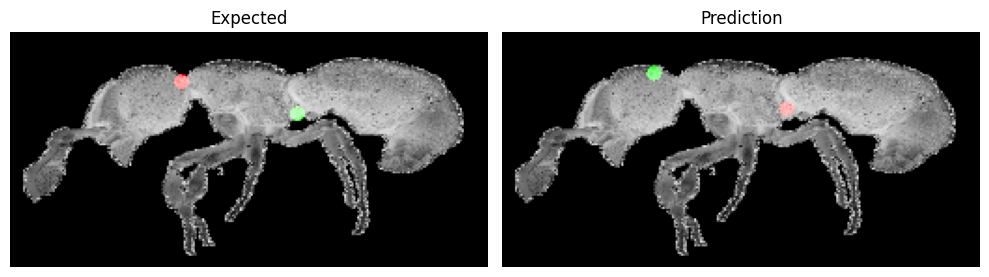

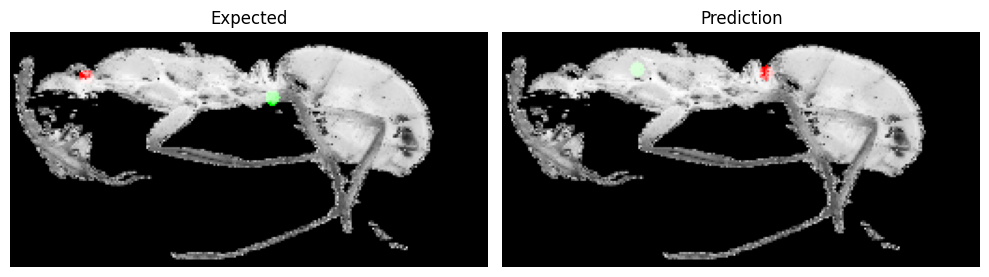

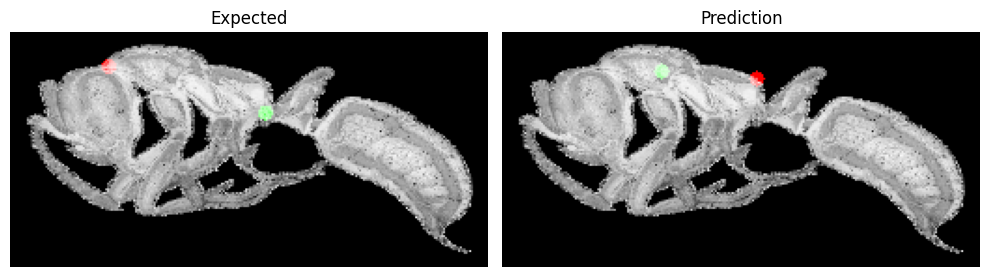

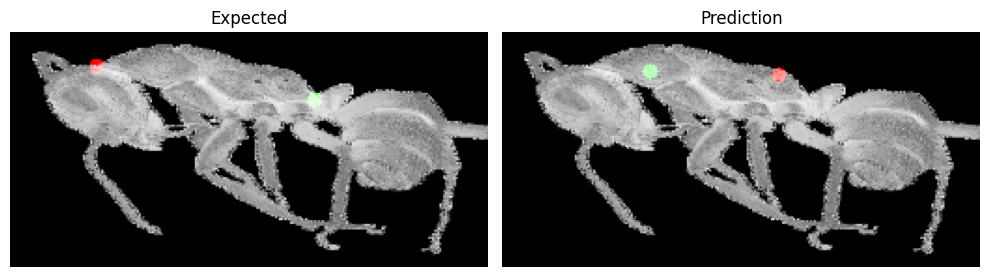

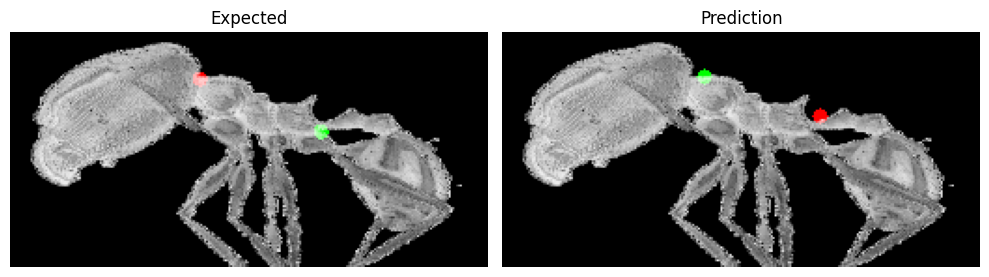

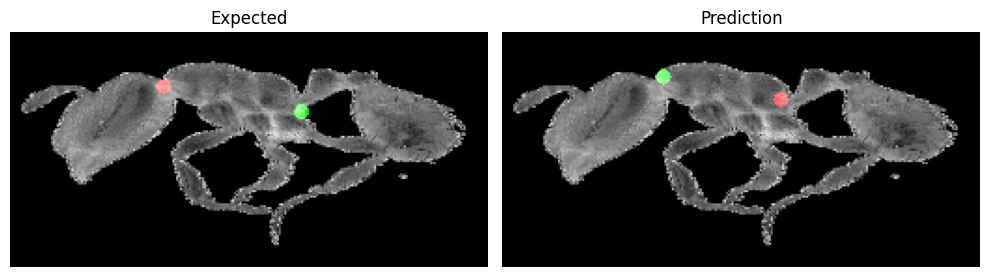

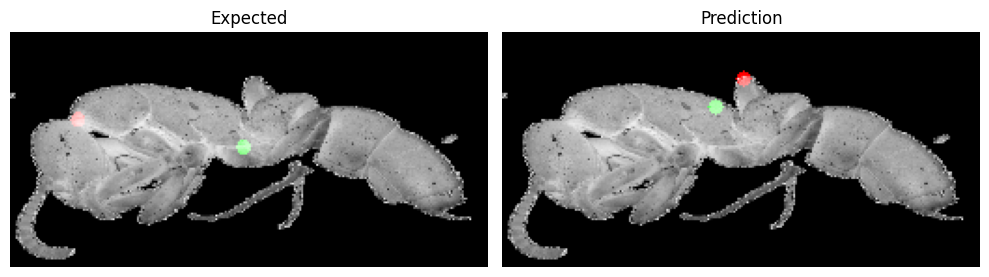

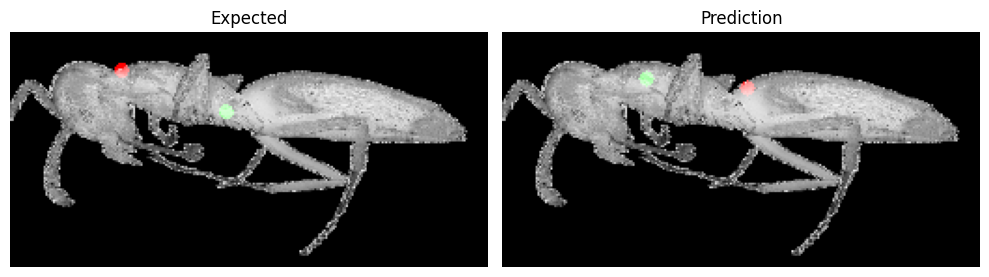

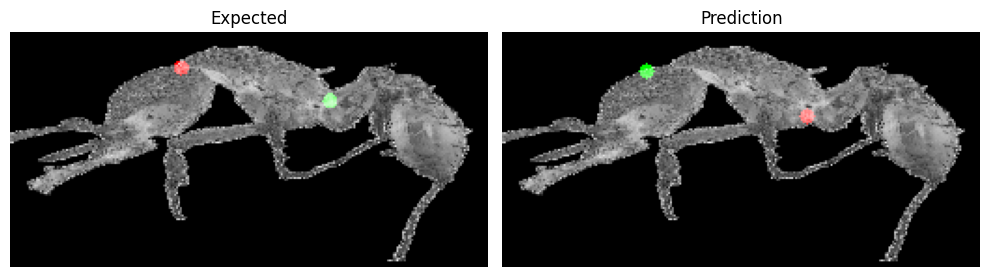

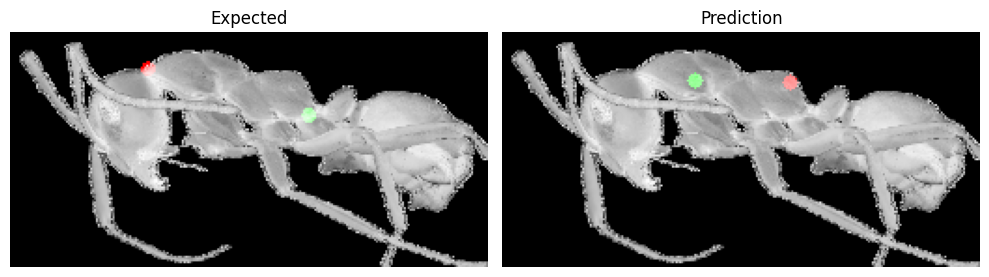

In [12]:
kpd_model.eval()

# Check predictions
Tools.plot_model_prediction(kpd_model, test_data, 10, conf_model = None, error_estimation_interval= [-1, 1], augment_images=False, device="mps")

Building error data for confidence model
Before clamp


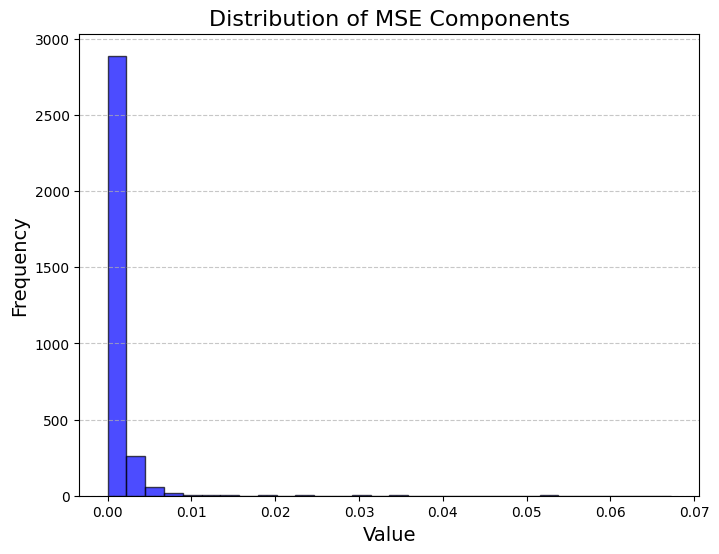

After clipping


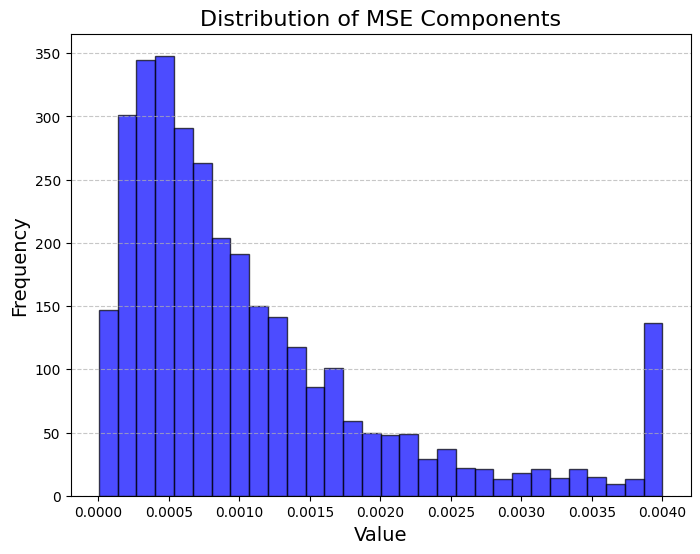

Normalized


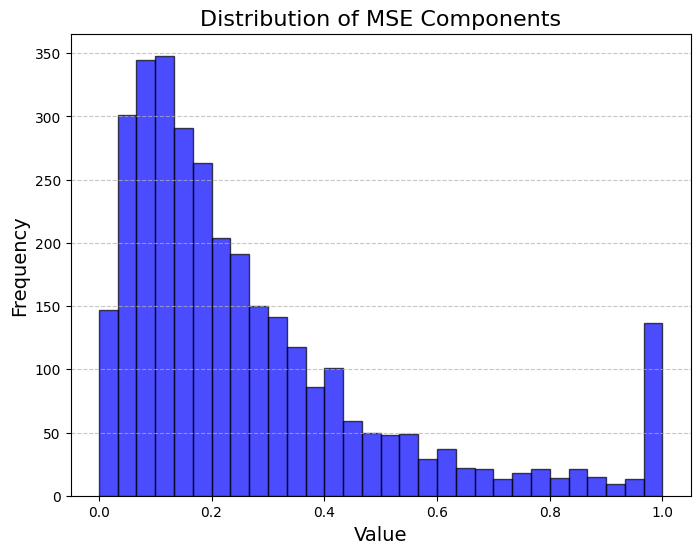

Building error data for confidence model
Before clamp


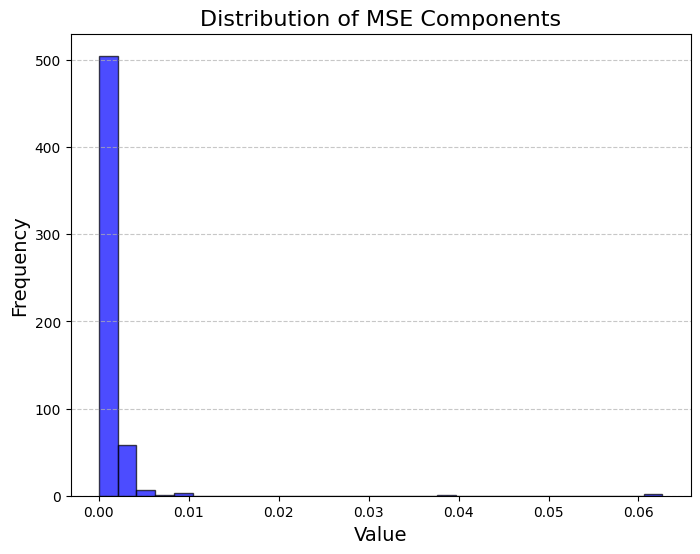

After clipping


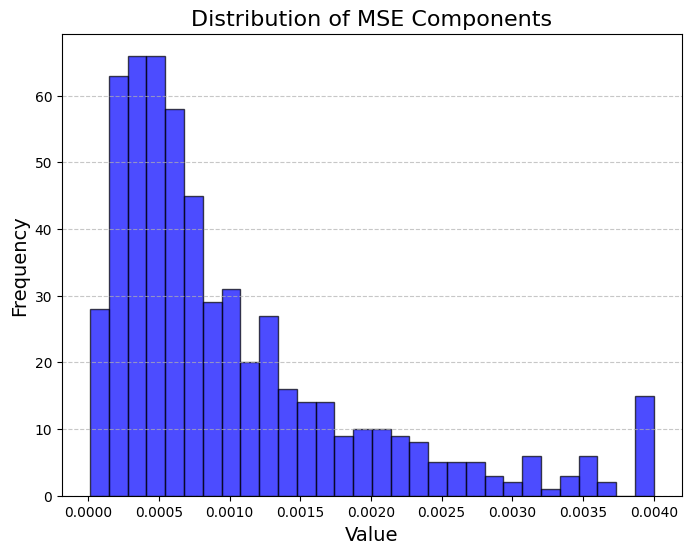

Normalized


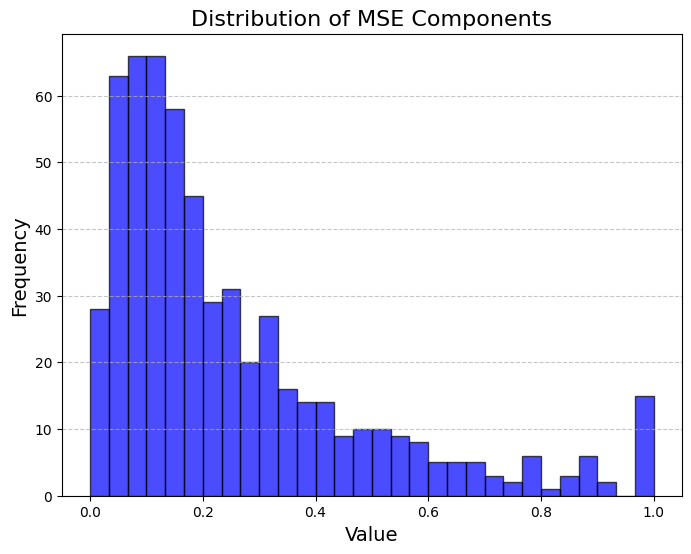

In [13]:
# Now train the confidence model !

from Models import PreTrainedConf
kpd_model.eval()

conf_model = PreTrainedConf.ConfidenceModel().to(device)

"""
Create error data by running the KPD model on the dataset and computing the errors.
!! WARNING !! It's far from ideal to use the same train set and test set as for the KPD model training because
it will naturally perform better on the train set so the train error data will be slightly biased (downwards), but we
don't have enough data to do otherwise.

The errors for each images are computed, clamped to a specific range to get rid of outliers and then normalized, 
so that the probability distribution of the errors is somewhat usable.
"""
train_error_data, norm_min, norm_max = Tools.build_error_data(kpd_model, train_data)
test_error_data, _, __ = Tools.build_error_data(kpd_model, test_data)

In [17]:
"""
Training the confidence model in the same way as the KPD model.
Note how it converges very quickly which implies that things are still far from perfect.
First, train it on augmented images.
"""
Tools.train_conf_model_fast(conf_model, kpd_model.pipeline, train_error_data, test_error_data, 50, len(test_error_data), 101, initial_lr=1e-6, lr_decay=0.99, device="mps", augment_training_images=True, feedback_rate=25, normalize_errors=False)

Epoch 0: test loss = 0.05349188297986984, lr = 9.9e-07
Epoch 25: test loss = 0.05109696835279465, lr = 7.700431458051553e-07
Epoch 50: test loss = 0.050916220992803574, lr = 5.98956006466161e-07
Epoch 75: test loss = 0.050759926438331604, lr = 4.658807751697933e-07
Epoch 100: test loss = 0.050766393542289734, lr = 3.623720178604968e-07


In [18]:
best_conf_model_state = conf_model.state_dict()

In [20]:
"""
Finetune it on specific non-augmented images.
"""
Tools.train_conf_model_fast(conf_model,  kpd_model.pipeline, train_error_data, test_error_data, 50, len(test_error_data), 201, initial_lr=1e-5, lr_decay=0.99, device="mps", augment_training_images=False, feedback_rate=50, normalize_errors=False)

Epoch 0: test loss = 0.05075818672776222, lr = 9.9e-06
Epoch 50: test loss = 0.049453750252723694, lr = 5.989560064661607e-06
Epoch 100: test loss = 0.04921652749180794, lr = 3.623720178604968e-06
Epoch 150: test loss = 0.04911254718899727, lr = 2.192372693664723e-06
Epoch 200: test loss = 0.049613580107688904, lr = 1.3263987810938206e-06


Confident predictions:
Error estimation =  0.11397677659988403


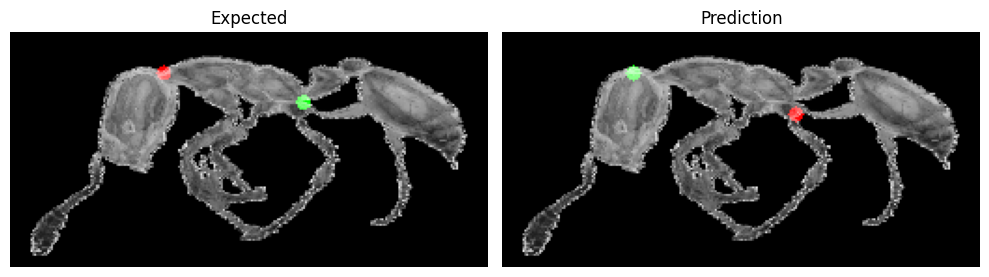

Error estimation =  0.08411087095737457


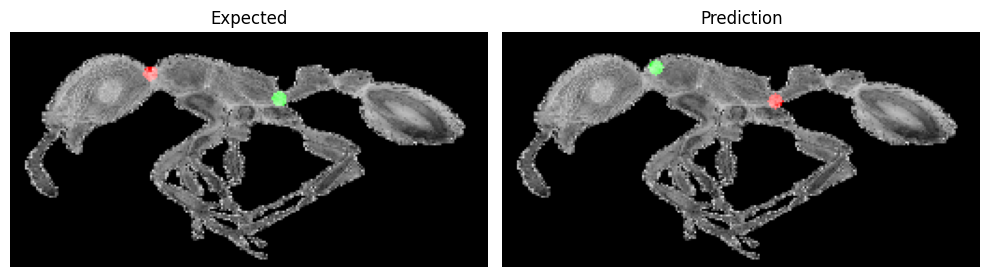

Error estimation =  0.06371332705020905


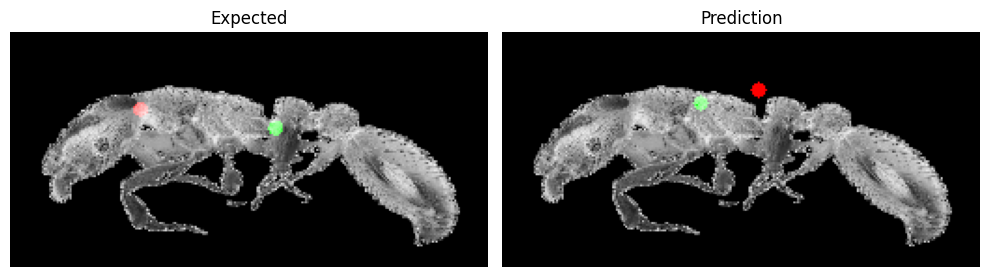

Error estimation =  0.1124219000339508


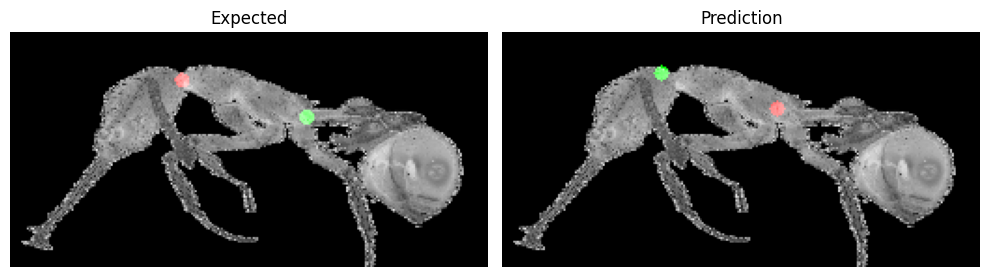

Error estimation =  0.009821396321058273


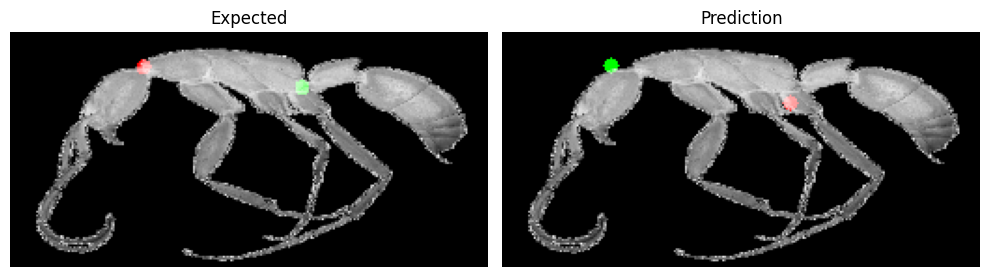

In [26]:
print("Confident predictions:")
Tools.plot_model_prediction(kpd_model, train_data, 40, conf_model=conf_model, error_estimation_interval=[-1, 0.12])

Low-confidence predictions
Error estimation =  0.4760550260543823


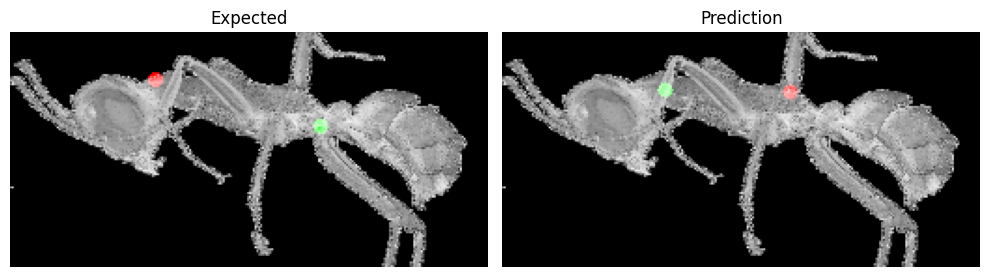

Error estimation =  0.4872085750102997


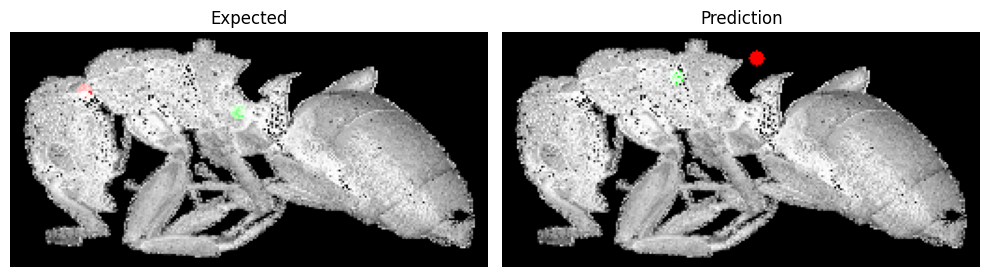

Error estimation =  0.5558146238327026


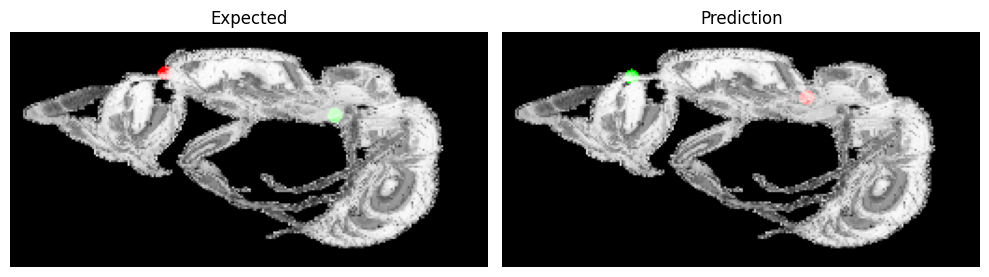

Error estimation =  0.8171020746231079


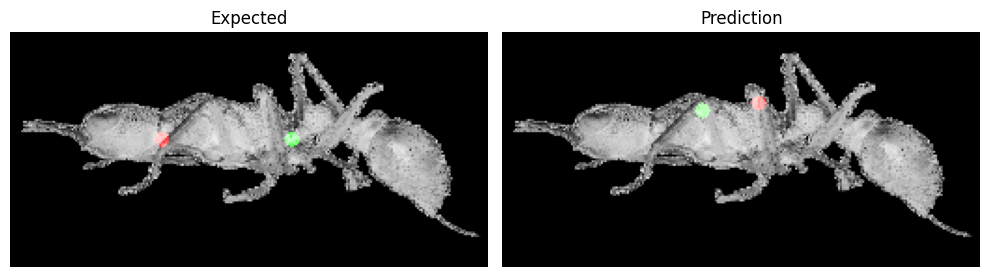

Error estimation =  0.4454706311225891


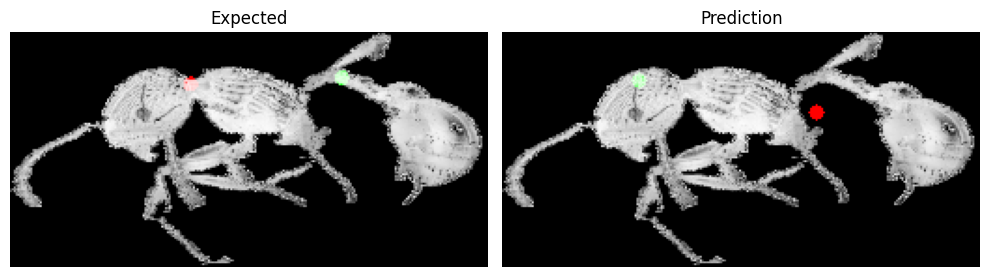

Error estimation =  0.7713617086410522


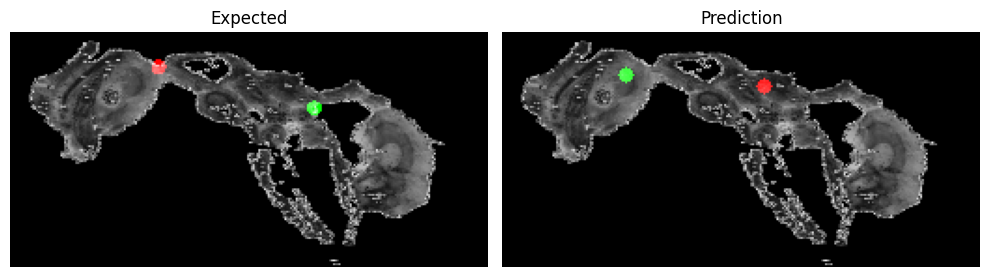

Error estimation =  0.5061331391334534


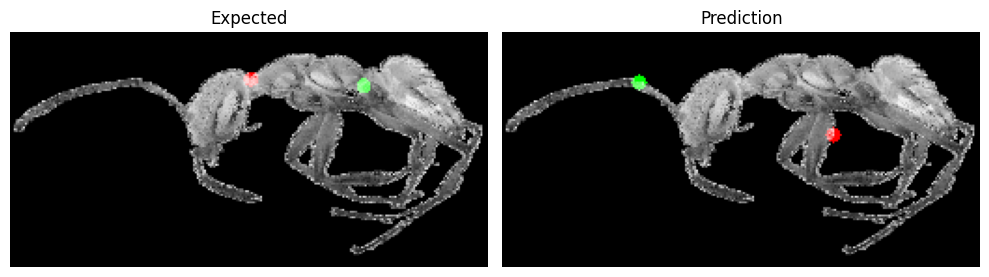

Error estimation =  0.40468457341194153


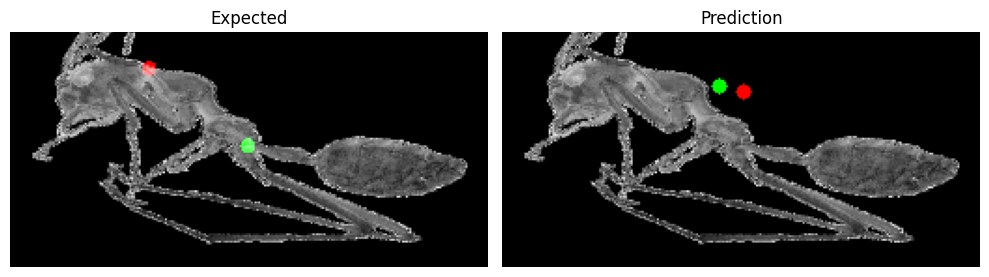

Error estimation =  0.4704799950122833


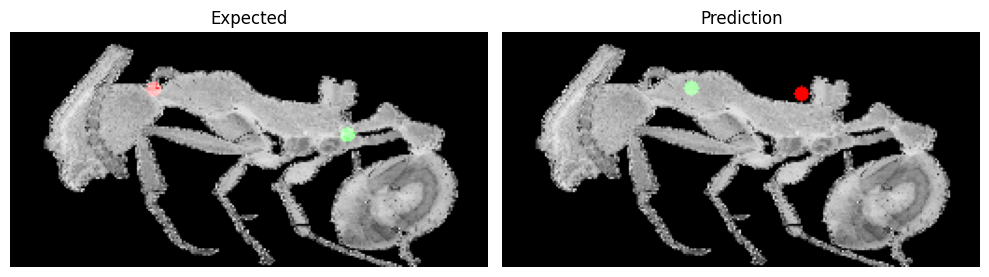

Error estimation =  0.627371072769165


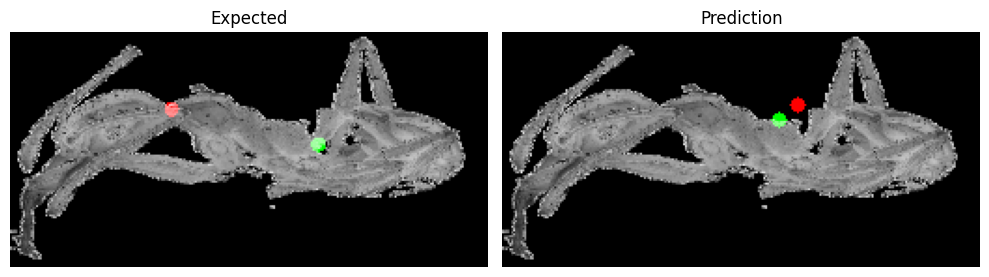

Error estimation =  0.6610605716705322


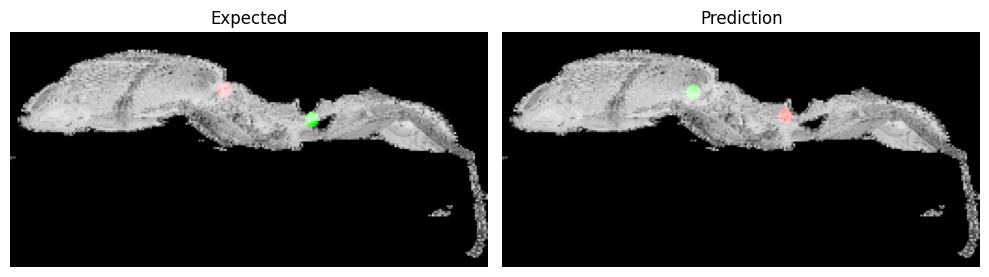

Error estimation =  0.6011050939559937


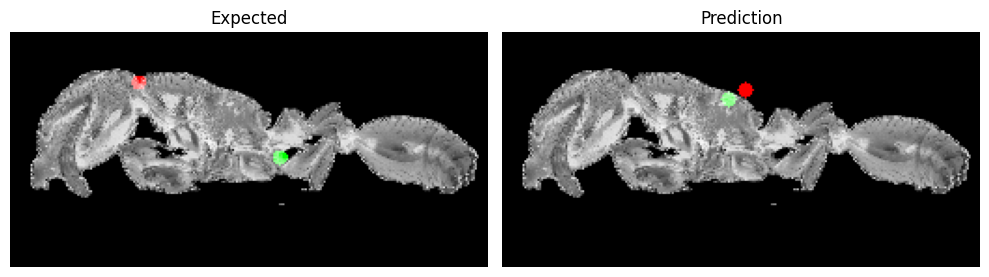

Error estimation =  0.8325889706611633


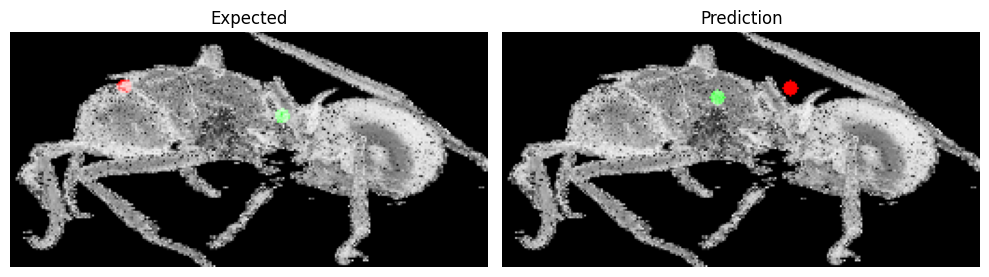

Error estimation =  0.5567848086357117


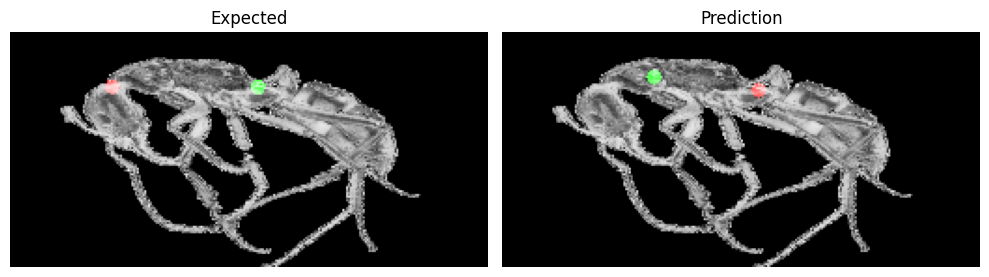

Error estimation =  0.4203658103942871


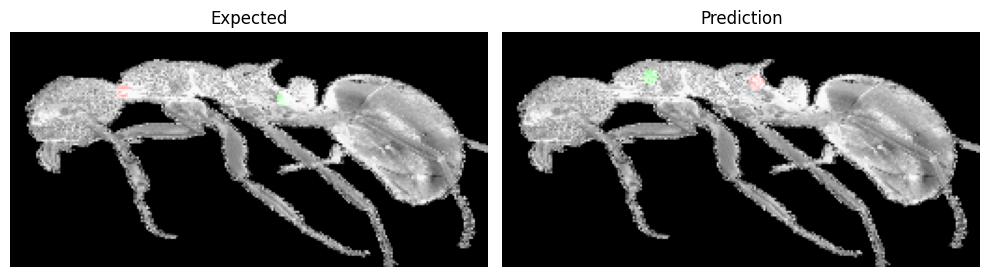

In [27]:
print("Low-confidence predictions")
Tools.plot_model_prediction(kpd_model, train_data, 80, conf_model=conf_model, error_estimation_interval=[0.4, 1])

In [28]:
torch.save(conf_model.state_dict(), "pretrainedConf_weights00166.pth")
torch.save(conf_model, "pretrainedConf_fullModel00166.pth")